In [ ]:
#| hide
#| nbflags skip_showdoc skip_exec

# Examples on how to use tiling utilities

## Tiling dataset for object detection or instance segmentation

In [ ]:
from pathlib import Path
from drone_detector.processing.tiling import *
import os, sys
import geopandas as gpd
import rasterio as rio
from rasterio import plot as rioplot
import random
import matplotlib.pyplot as plt

This example uses deadwood data from Hiidenportti. For this purpose, we use only 5 tiles to speed things up.

In [ ]:
tile_folder = Path('../data/hiidenportti/raw/envelope_patches/')
vector_folder = Path('../data/hiidenportti/raw/envelope_vectors/')

outpath = Path('../data/hiidenportti/processed_example/')

tiles = sorted(os.listdir(tile_folder))[:5]
vectors = sorted([f for f in os.listdir(vector_folder) if f.endswith('geojson')])[:5]
assert len(tiles) == len(vectors)

These virtual plots are tiled into 512 times 512 pixel grid. Then, the vector files are tiled using the same grid. By setting `min_area_pct` to 0.25, we discard all polygons that are cut so that their area is less than 25% of the original area. `Tiler.tile_vector` discards all grid cells that don't contain any polygons

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
for d in os.listdir(outpath):
    print(f"""{d} was split into {len(os.listdir(outpath/d/'raster_tiles'))} raster cells and {len(os.listdir(outpath/d/"vector_tiles"))} vector cells""")

104_112_Hiidenportti_Chunk9_orto was split into 28 raster cells and 17 vector cells
104_111_Hiidenportti_Chunk4_orto was split into 16 raster cells and 16 vector cells
104_118_Hiidenportti_Chunk6_orto was split into 40 raster cells and 38 vector cells
104_102_Hiidenportti_Chunk9_orto was split into 16 raster cells and 16 vector cells
104_119_Hiidenportti_Chunk6_orto was split into 48 raster cells and 46 vector cells


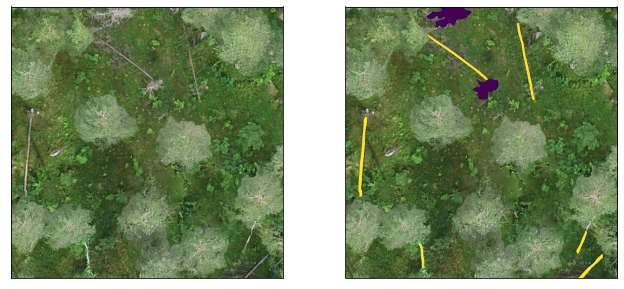

In [ ]:
ex_file = random.sample(os.listdir(outpath/d/'vector_tiles'), 1)[0]
fig, axs = plt.subplots(1,2, figsize=(11,5))
for a in axs:
    a.set_xticks([])
    a.set_yticks([])
with rio.open(outpath/d/f"raster_tiles/{ex_file.replace('geojson', 'tif')}") as im:
    rioplot.show(im, ax=axs[0])
    mask = gpd.read_file(outpath/d/'vector_tiles'/ex_file)
    rioplot.show(im, ax=axs[1])
    mask.plot(ax=axs[1], column='groundwood')

## Tiling dataset for semantic segmentation

In [ ]:
tile_folder = Path('../data/hiidenportti/raw/envelope_patches/')
vector_folder = Path('../data/hiidenportti/raw/envelope_vectors/')

outpath = Path('../data/hiidenportti/processed_unet_example/')

tiles = sorted(os.listdir(tile_folder))[:5]
vectors = sorted([f for f in os.listdir(vector_folder) if f.endswith('geojson')])[:5]
assert len(tiles) == len(vectors)

For semantic segmentation, we split the data into 256 times 256 pixel grid. Vector files are then tiled and rasterized to the same grid, in such way that raster images are saved. This method saves target mask for each cell even if they don't contain any masks. 

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 256
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_and_rasterize_vector(vector_folder/shp_fname, column='groundwood')

0it [00:00, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

In [ ]:
for d in os.listdir(outpath):
    print(f"""{d} was split into {len(os.listdir(outpath/d/'raster_tiles'))} raster cells and {len(os.listdir(outpath/d/"rasterized_vector_tiles"))} vector cells""")

104_112_Hiidenportti_Chunk9_orto was split into 126 raster cells and 126 vector cells
104_111_Hiidenportti_Chunk4_orto was split into 64 raster cells and 64 vector cells
104_118_Hiidenportti_Chunk6_orto was split into 160 raster cells and 160 vector cells
104_102_Hiidenportti_Chunk9_orto was split into 64 raster cells and 64 vector cells
104_119_Hiidenportti_Chunk6_orto was split into 192 raster cells and 192 vector cells


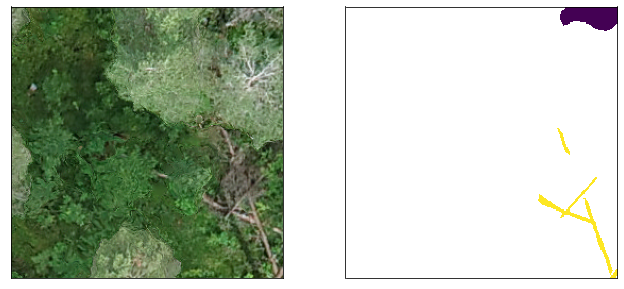

In [ ]:
ex_file = random.sample(os.listdir(outpath/d/'rasterized_vector_tiles'), 1)[0]
fig, axs = plt.subplots(1,2, figsize=(11,5))
for a in axs:
    a.set_xticks([])
    a.set_yticks([])
with rio.open(outpath/d/"raster_tiles"/ex_file) as im:
    rioplot.show(im, ax=axs[0])
with rio.open(outpath/d/"rasterized_vector_tiles"/ex_file) as mask:
    rioplot.show(mask, ax=axs[1])


## Tiling non-geospatial data

So far `Tiler` doesn't really support data without sensible geotransform. It is, however, possible to work around and might be available in the future.

In [ ]:
map_tile = '../data/historic_map/raw/kartta.png'
mask_tile = '../data/historic_map/raw/swampbin.png'
outpath = Path('../data/historic_map/processed')

In [ ]:
tilesize = 224
map_tiler = Tiler(outpath=outpath, gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
map_tiler.tile_raster(map_tile)
#map_tiler.raster_path = outpath/'mask_tiles'
#map_tiler.tile_raster(mask_tile)

/opt/conda/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


0it [00:00, ?it/s]

In [ ]:
from osgeo import gdal

We have to manually set pixel coordinates as geocoordinates, provide GCPs and change the order of `projWin`

In [ ]:
raster = gdal.Open(map_tile)
for row in (map_tiler.grid.itertuples()):
    coords = list(row.geometry.exterior.coords)[:-1]
    gcp_list = []
    gcp_list.append(gdal.GCP(coords[0][0],coords[0][1],1,0,-0))
    gcp_list.append(gdal.GCP(coords[1][0],coords[1][1],1,224,-0))
    gcp_list.append(gdal.GCP(coords[2][0],coords[2][1],1,224,-224))
    gcp_list.append(gdal.GCP(coords[3][0],coords[3][1],1,0,-224))
    translate_kwargs = {'GCPs': gcp_list}
    tempraster = gdal.Translate(f'{map_tiler.raster_path}/{row.cell}.tif', raster,
                                projWin=[row.geometry.bounds[0], row.geometry.bounds[1], 
                                         row.geometry.bounds[2], row.geometry.bounds[3]],
                                **translate_kwargs
                               )
    tempraster = None
raster = None

In [ ]:
map_tiler.raster_path = outpath/'mask_tiles'
map_tiler.tile_raster(mask_tile)

/opt/conda/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


0it [00:00, ?it/s]

In [ ]:
raster = gdal.Open(mask_tile)
for row in (map_tiler.grid.itertuples()):
    coords = list(row.geometry.exterior.coords)[:-1]
    gcp_list = []
    gcp_list.append(gdal.GCP(coords[0][0],coords[0][1],1,0,-0))
    gcp_list.append(gdal.GCP(coords[1][0],coords[1][1],1,224,-0))
    gcp_list.append(gdal.GCP(coords[2][0],coords[2][1],1,224,-224))
    gcp_list.append(gdal.GCP(coords[3][0],coords[3][1],1,0,-224))
    translate_kwargs = {'GCPs': gcp_list,
                        'outputType': gdal.GDT_Byte}
    tempraster = gdal.Translate(f'{map_tiler.raster_path}/{row.cell}.tif', raster,
                                projWin=[row.geometry.bounds[0], row.geometry.bounds[1], 
                                         row.geometry.bounds[2], row.geometry.bounds[3]],
                                **translate_kwargs
                               )
    tempraster = None
raster = None

Example data here is historical map from Evo area, and the target mask is for marshes and swamps.

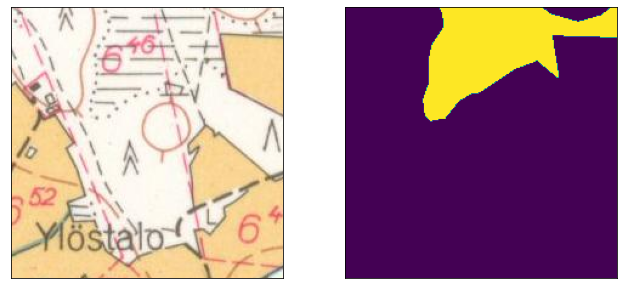

In [ ]:
ex_file = random.sample(os.listdir(outpath/'raster_tiles'), 1)[0]
fig, axs = plt.subplots(1,2, figsize=(11,5))
for a in axs:
    a.set_xticks([])
    a.set_yticks([])
with rio.open(outpath/"raster_tiles"/ex_file) as im:
    rioplot.show(im, ax=axs[0])
with rio.open(outpath/"mask_tiles"/ex_file) as mask:
    rioplot.show(mask, ax=axs[1])
